https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_audio_examples.ipynb

In [1]:
import glob
import os
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn
import torchaudio

# libreries from adversarial robustness toolbox
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
from art import config
from art.defences.preprocessor import Mp3Compression
from art.utils import get_file

In [2]:
device = torch.device("cpu") 
device

device(type='cpu')

In [3]:
OUTPUT_SIZE = 8000
ORIGINAL_SAMPLING_RATE = 48000
DOWNSAMPLED_SAMPLING_RATE = 8000

In [4]:
AUDIO_DATA_PATH = os.path.join(config.ART_DATA_PATH, "audiomnist/test")
AUDIO_MODEL_PATH = os.path.join(config.ART_DATA_PATH, "adversarial_audio_model.pt")

In [5]:
AUDIO_DATA_PATH

'C:\\Users\\Usuario\\.art\\data\\audiomnist/test'

In [5]:
# set seed
np.random.seed(123)

In [5]:
# the next download the AudioMNIST data and pretrained model
get_file('adversarial_audio_model.pt', 'https://www.dropbox.com/s/o7nmahozshz2k3i/model_raw_audio_state_dict_202002260446.pt?dl=1')
get_file('audiomnist.tar.gz', 'https://api.github.com/repos/soerenab/AudioMNIST/tarball');

In [14]:
import os
import subprocess


# Crear el directorio si no existe
os.makedirs(AUDIO_DATA_PATH, exist_ok=True)

# Comando para extraer el archivo con tar en Windows
command = [
    "tar", "-xf", f"{AUDIO_DATA_PATH}/audiomnist.tar.gz",
    "-C", AUDIO_DATA_PATH,
    "--strip-components=2",
    "--exclude=**/*/{01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48}"
]

# Ejecutar el comando
subprocess.run(command, shell=True)

CompletedProcess(args=['tar', '-xf', 'C:/Users/Usuario/.art/data/cifar-10-batches-py/audiomnist.tar.gz', '-C', 'C:/Users/Usuario/.art/data/cifar-10-batches-py', '--strip-components=2', '--exclude=**/*/{01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48}'], returncode=1)

In [6]:
class AudioMNISTDataset(torch.utils.data.Dataset):
    """Dataset object for the AudioMNIST data set."""
    def __init__(self, root_dir, transform=None, verbose=False):
        self.root_dir = root_dir
        self.audio_list = sorted(glob.glob(f"{root_dir}/*/*.wav"))
        self.transform = transform
        self.verbose = verbose

    def __len__(self):
        return len(self.audio_list)

    def __getitem__(self, idx):
        audio_fn = self.audio_list[idx]
        if self.verbose:
            print(f"Loading audio file {audio_fn}")
        #waveform, sample_rate = torchaudio.load_wav(audio_fn)
        waveform, sample_rate = torchaudio.load(audio_fn.replace("\\","/"))
        #waveform, sample_rate =  sf.read(audio_fn.replace("/", ))
        if self.transform:
            waveform = self.transform(waveform)
        sample = {
            'input': waveform,
            'digit': int(os.path.basename(audio_fn).split("_")[0])
        }
        return sample

class _ResampleWavefForm(object):
    """Resample signal frequency."""
    def __init__(self, orig_freq, new_freq):
        self.orig_freq = orig_freq
        self.new_freq = new_freq

    def __call__(self, waveform):
        return self._resample_waveform(waveform)

    def _resample_waveform(self, waveform):
        resampled_waveform = torchaudio.transforms.Resample(
            orig_freq=self.orig_freq,
            new_freq=self.new_freq,
        )(waveform)
        return resampled_waveform

class PreprocessRaw(object):
    """Transform audio waveform of given shape."""
    def __init__(self, size_out=OUTPUT_SIZE, orig_freq=ORIGINAL_SAMPLING_RATE, new_freq=DOWNSAMPLED_SAMPLING_RATE):
        self.size_out = size_out
        self.orig_freq = orig_freq
        self.new_freq = new_freq

    def __call__(self, waveform):
        transformed_waveform = _ZeroPadWaveForm(self.size_out)(_ResampleWavefForm(self.orig_freq, self.new_freq)(waveform))
        return transformed_waveform

class _ZeroPadWaveForm(object):
    """Apply zero-padding to waveform.        
    """
    def __init__(self, size_out):
        self.size_out = size_out
    def __call__(self, waveform):
        return self._zero_pad_waveform(waveform)

    def _zero_pad_waveform(self, waveform):
        padding_total = self.size_out - waveform.shape[-1]
        padding_left = np.random.randint(padding_total + 1)
        padding_right = padding_total - padding_left
        padded_waveform = torch.nn.ConstantPad1d(
            (padding_left, padding_right),
            0
        )(waveform)
        return padded_waveform
            
        
        

In [7]:
class RawAudioCNN(nn.Module):
    """Adaption of AudioNet (arXiv:1807.03418)."""
    def __init__(self):
        super().__init__()
        # 1 x 8000
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 100, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2))
        # 32 x 4000
        self.conv2 = nn.Sequential(
            nn.Conv1d(100, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        # 64 x 2000
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        # 128 x 1000
        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        # 128 x 500
        self.conv5 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        # 128 x 250
        self.conv6 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        # 128 x 125
        self.conv7 = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        # 64 x 62
        self.conv8 = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            # maybe replace pool with dropout here
            nn.MaxPool1d(2, stride=2))

        # 32 x 30
        self.fc = nn.Linear(32 * 30, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = x.view(x.shape[0], 32 * 30)
        x = self.fc(x)
        return x

In [8]:
def display_waveform(waveform, title="", sr=8000):
    """Display waveform plot and audio play UI."""
    plt.figure()
    plt.title(title)
    plt.plot(waveform)
    ipd.display(ipd.Audio(waveform, rate=sr))

In [9]:
AUDIO_MODEL_PATH

'C:\\Users\\Usuario\\.art\\data\\adversarial_audio_model.pt'

In [10]:
AUDIO_DATA_PATH="D:/Github/audiodata"
AUDIO_MODEL_PATH

'C:\\Users\\Usuario\\.art\\data\\adversarial_audio_model.pt'

In [16]:
# model dataset
audiomnist_test = AudioMNISTDataset(
    root_dir = AUDIO_DATA_PATH,
    transform = PreprocessRaw()
)

# load pretrained model
model = RawAudioCNN()
model.to(device)
model.load_state_dict(
    torch.load(AUDIO_MODEL_PATH,weights_only=True)
)
model.eval();

In [12]:
audiomnist_test.__len__()

1000

***

## Adversarial examples

The attack will corrupt the spoken audio and will be misclassfied as 9.

*The Projected Gradient Descent attack is an iterative method in which, after each iteration, the perturbation is projected on an lp-ball of specified radius (in addition to clipping the values of the adversarial sample so that it lies in the permitted data range). This is the attack proposed by Madry et al. for adversarial training.*

In [13]:
classifier_art = PyTorchClassifier(
    model=model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=None,
    input_shape =[1, DOWNSAMPLED_SAMPLING_RATE],
    nb_classes=10,
    clip_values=(-2**15, 2**15 - 1)
)

In [14]:
audiomnist_test[100]

{'input': tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), 'digit': 2}

In [17]:
sample = audiomnist_test[100]

waveform = sample["input"]
label = sample["digit"]

epsilon =.2
pgd = ProjectedGradientDescent(classifier_art, eps=epsilon)
adv_waveform = pgd.generate(
    x=torch.unsqueeze(waveform, 0).numpy()
)

# evaluate the classifier on the adversarial example
with torch.no_grad():
    _, pred = torch.max(model(torch.unsqueeze(waveform, 0).to(device)), 1)
    _, pred_adv = torch.max(model(torch.from_numpy(adv_waveform).to(device)), 1)

# print results
print(f"Original prediction (ground truth):\t{pred.tolist()[0]} ({label})")
print(f"Adversarial prediction:\t\t\t{pred_adv.tolist()[0]}")

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Original prediction (ground truth):	2 (2)
Adversarial prediction:			6


As we can see the given test example, the model correcly classified it as 2. Applying PGD, we can create an adversarial example that is now classfied as 9.

Displaying the adversarial example

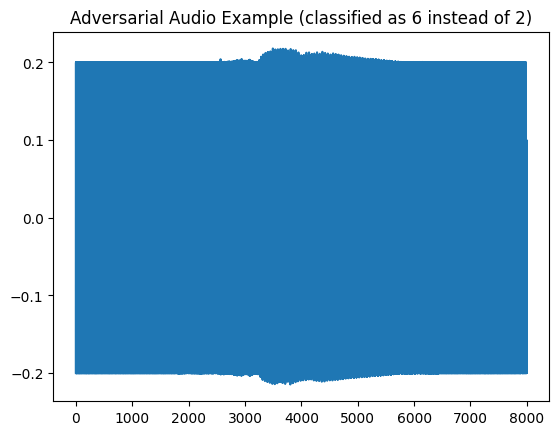

In [18]:
display_waveform(adv_waveform[0,0,:], title=f"Adversarial Audio Example (classified as {pred_adv.tolist()[0]} instead of {pred.tolist()[0]})")

Original example

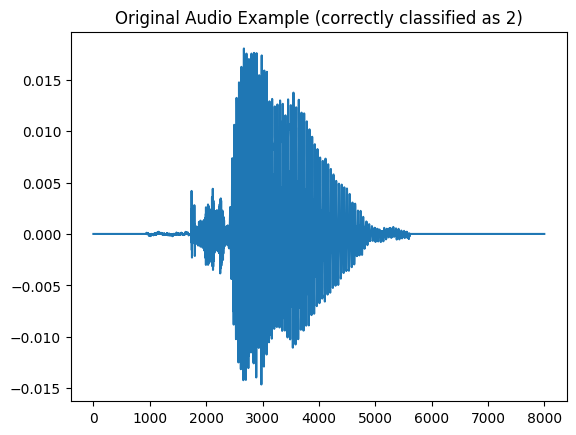

In [43]:
display_waveform(waveform.numpy()[0,:], title=f"Original Audio Example (correctly classified as {pred.tolist()[0]})")

***

In [31]:
# load a test sample
sample = audiomnist_test[50]

waveform = sample['input']
label = sample['digit']

# craft adversarial example with PGD
epsilon = 0.5
pgd = ProjectedGradientDescent(classifier_art, eps=epsilon)
adv_waveform = pgd.generate(
    x=torch.unsqueeze(waveform, 0).numpy()
)

# evaluate the classifier on the adversarial example
with torch.no_grad():
    _, pred = torch.max(model(torch.unsqueeze(waveform, 0).to(device)), 1)
    _, pred_adv = torch.max(model(torch.from_numpy(adv_waveform).to(device)), 1)

# print results
print(f"Original prediction (ground truth):\t{pred.tolist()[0]} ({label})")
print(f"Adversarial prediction:\t\t\t{pred_adv.tolist()[0]}")

D:/Github/audiodata\59\1_59_0.wav


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Original prediction (ground truth):	2 (1)
Adversarial prediction:			6


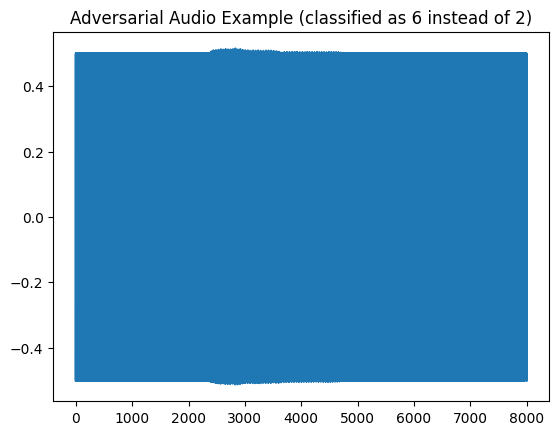

In [32]:
# display adversarial example
display_waveform(adv_waveform[0,0,:], title=f"Adversarial Audio Example (classified as {pred_adv.tolist()[0]} instead of {pred.tolist()[0]})")

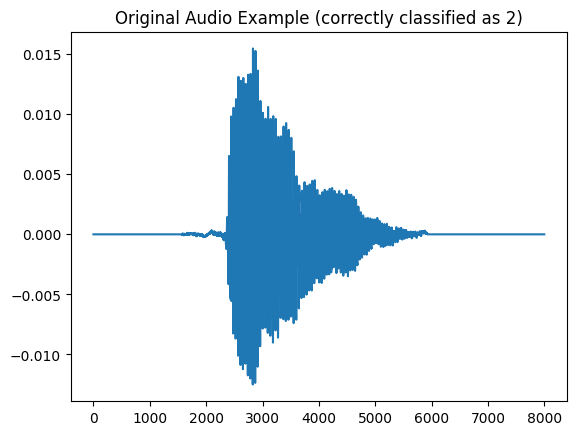

In [33]:
# display original example
display_waveform(waveform.numpy()[0,:], title=f"Original Audio Example (correctly classified as {pred.tolist()[0]})")